<a href="https://colab.research.google.com/github/hughesymendes/TIC-27491137/blob/Dip3_model/dip3_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install lightkurve

!pip install exoplanet

!pip install pandas==0.25

     |████████████████████████████████| 501kB 2.8MB/s 
     |████████████████████████████████| 25.2MB 5.2MB/s 
     |████████████████████████████████| 4.5MB 39.9MB/s 
     |████████████████████████████████| 235kB 25.6MB/s 
     |████████████████████████████████| 2.7MB 39.5MB/s 
  Created wheel for oktopus: filename=oktopus-0.1.2-cp36-none-any.whl size=12779 sha256=39eb66739303d89e5877efc2541c9a9b80dc35cce4aa296d378344a160013ad9
  Stored in directory: /root/.cache/pip/wheels/9b/90/81/098fc66ee56166d63c9a8fc0a9672ae7b3423396a588ec952a
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=bc570f22c72c8673e0e106f8caf06ce674021a55a30fd46228ccf116c4f81420
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
  Created wheel for fbpca: filename=fbpca-1.0-cp36-none-any.whl size=11376 sha256=95723852e4091c2272b7e50bcbfe2a8b893e22c8404348ff7d90fbc7e01a3db4
  Stored in directory: /root/.cache/pip/wheels/5

/usr/local/lib/python3.6/dist-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


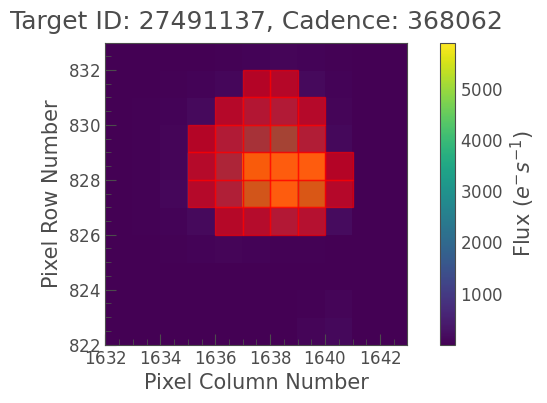

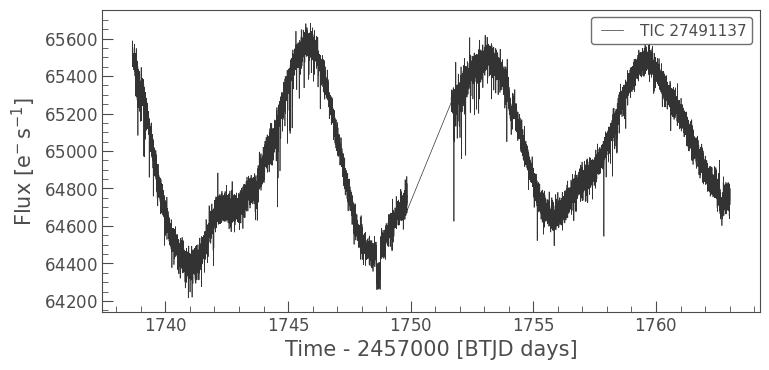

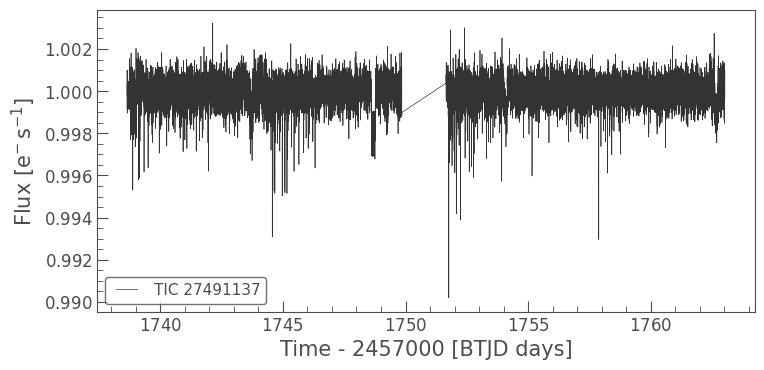

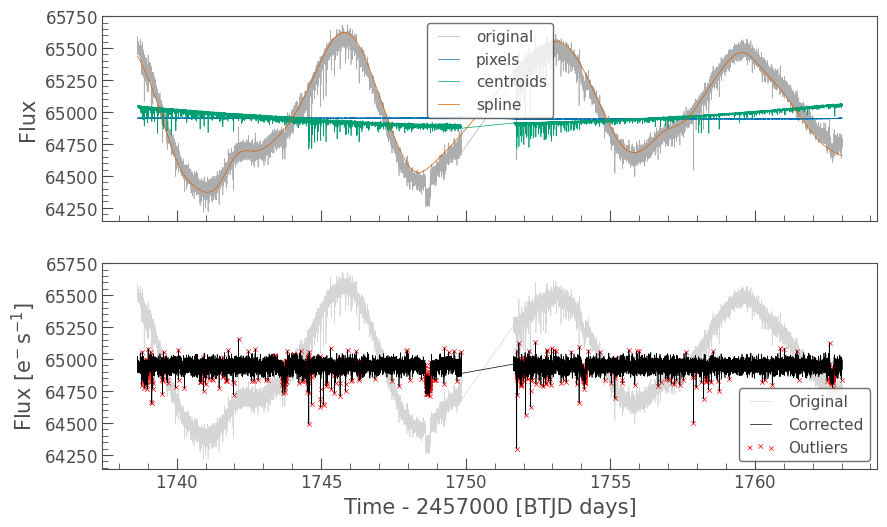

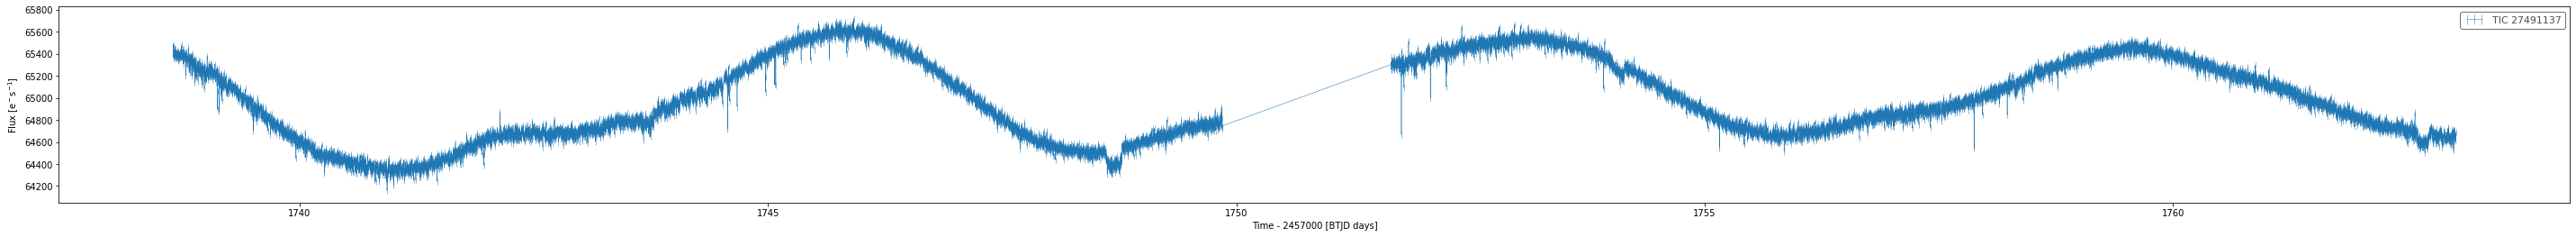

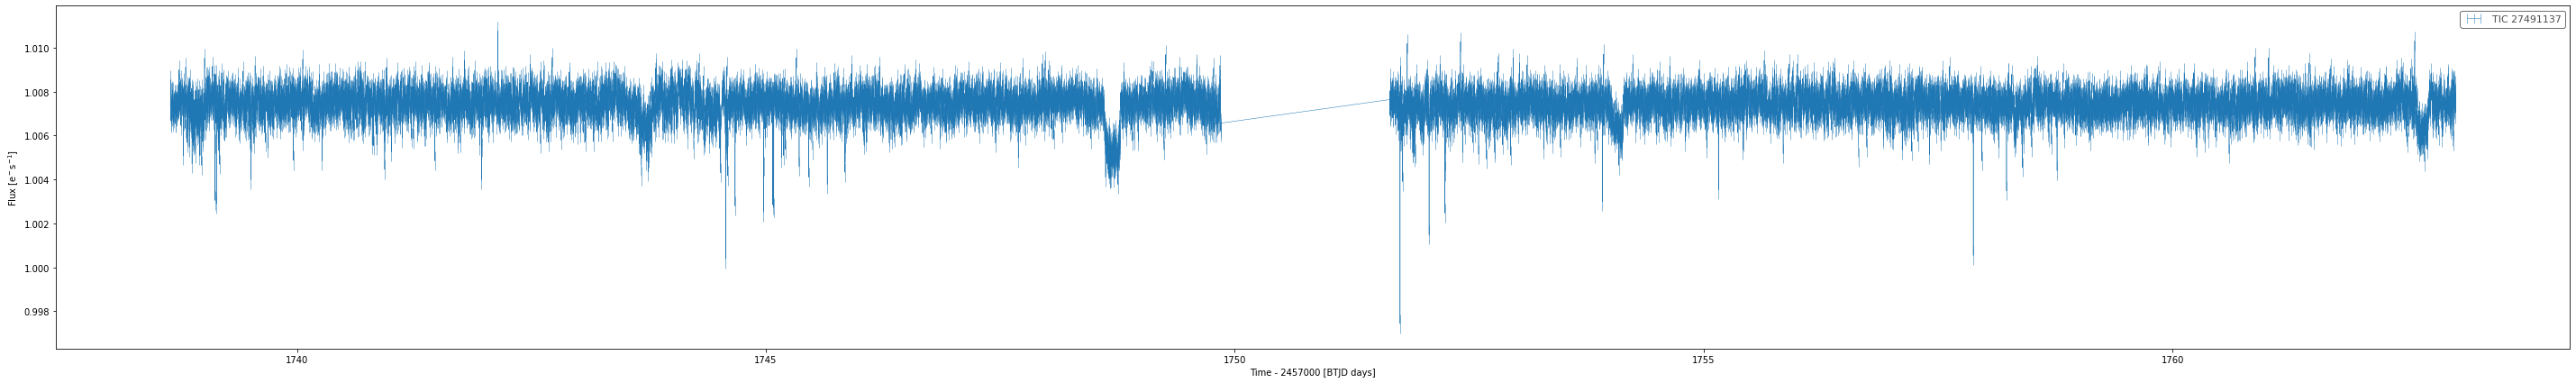

In [1]:

import lightkurve as lk
from lightkurve import search_targetpixelfile
from lightkurve import TessTargetPixelFile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#downloading data from MAST
tpf = search_targetpixelfile("TIC 27491137").download()
aper = tpf.create_threshold_mask()
tpf.plot(aperture_mask = aper, mask_color = "red")

#Creating Lightcurve from TPF
lc = tpf.to_lightcurve()

#Masking out Argabrightening events
mask = np.isfinite(lc.flux_err)
clipped = lc[mask]

clipped.plot()

flc = clipped.flatten(window_length = 1001).plot()

pixels = tpf.flux[mask][:, ~aper]
dm1 = lk.DesignMatrix(pixels, name='pixels').pca(3).append_constant()

# We'll do a 3D low order polynomial in TIME, COLUMN CENTROID and ROW CENTROID:

r, c = tpf[mask].estimate_centroids()
r, c = r - np.median(r), c - np.median(c)


t = (lc[mask].cadenceno - np.median(lc.cadenceno))/(len(lc.time))


dm2 = lk.DesignMatrix(np.vstack([r, c, r*c, r**2, c**2, r**2*c, c**2*r, r**2*c**2,
                                t*r, t*c, t*r*c, t*r**2, t*c**2, t*r**2*c, t*c**2*r, t*r**2*c**2]).T, name='centroids')

spline = lk.designmatrix.create_spline_matrix(lc[mask].time, n_knots=35)

dm = lk.DesignMatrixCollection([dm1, dm2, spline])

# Make a very hacky cadence mask:
b = lc[mask].flatten(1001).bin(10)
_, m = b.remove_outliers(3, return_mask=True)
cadence_mask = np.interp(lc[mask].time, b.time, m) != 0

#Tried to make a mask by adding all the areas that i wanted to mask, however it errored out saying needed to be 2D?
#mask = (clipped[3300:3900], clipped[7100:7350], clipped[9500:10000], clipped[15700:]) = True

r = lk.RegressionCorrector(lc[mask])
r.correct(dm, sigma=3., cadence_mask=~cadence_mask)

r.diagnose()

# Remove INSTRUMENT systematics
corr = (r.diagnostic_lightcurves['pixels'] + r.diagnostic_lightcurves['centroids']).flux
corr -= np.median(corr)
clc = (lc[mask] - corr)

fig, ax = plt.subplots(figsize=(50, 4))
(clc).errorbar(ls='-', ax=ax)

# Divide through by STELLAR flux
stellar_flux = r.diagnostic_lightcurves['spline'].flux + np.median(clc.flux)

fig, ax = plt.subplots(figsize=(50, 7))
(clc/stellar_flux).errorbar(ls='-', ax=ax)

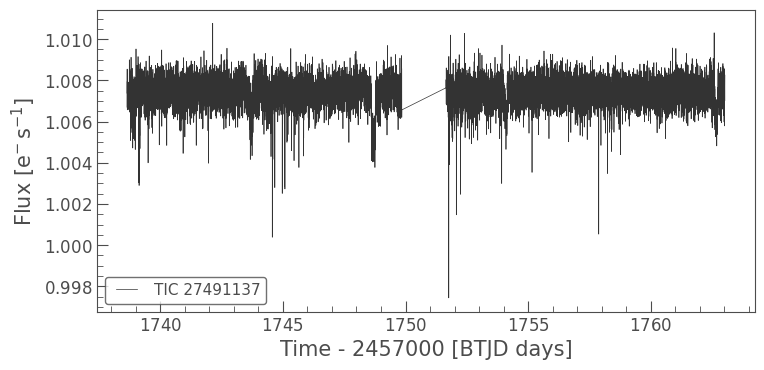

In [2]:
clean_lc = (clc/stellar_flux)
clean_lc.plot()

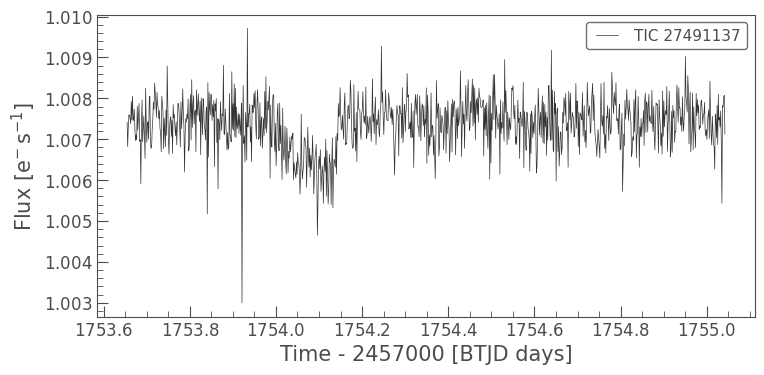

In [11]:
dip3 = clean_lc[9500:10500]
dip3.plot()

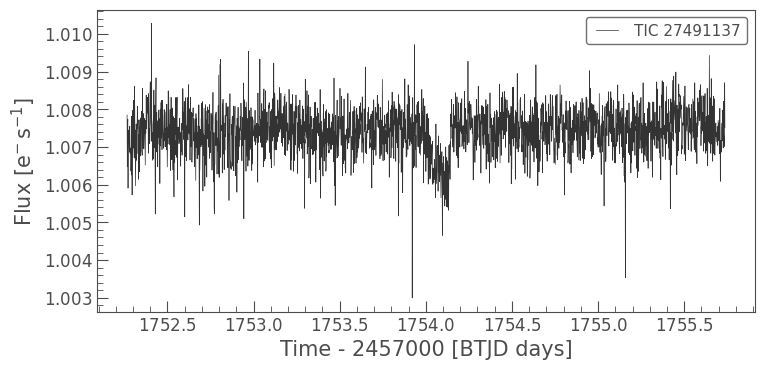

In [4]:
dip3 = clean_lc[8500:11000]
dip3.plot()

In [0]:
d1x = np.append( np.array( [], dtype="float64" ),dip3.time )
d1y = np.append( np.array( [], dtype="float64" ), dip3.flux - 1.0075 )
d1y_err = np.append( np.array( [], dtype="float64" ), dip3.flux_err )

In [0]:
d1x

array([1752.26561234, 1752.26700121, 1752.26839007, ..., 1755.73362162,
       1755.73501049, 1755.73639936])

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


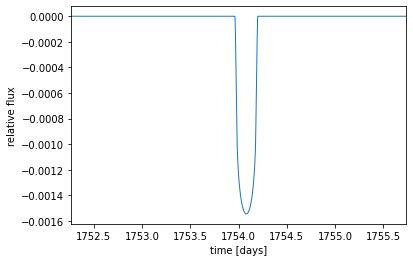

In [21]:
import numpy as np
import exoplanet as xo

# The light curve calculation requires an orbit
orbit = xo.orbits.KeplerianOrbit(period= np.random.uniform(1,50,1), t0 =1754.08, r_star = 0.78, m_star = 0.87)

# Compute a limb-darkened light curve using starry
t = np.linspace(1752.26561234,1755.73639936, 2500)
#found values from a paper for Kepler and TESS that gives a=0.4984, b= 0.1939 (using quadratic law).
# 'u' seems to be linear but is only given as one value whereas 'u' here is 2D so I've input values 
# In between the two closest stellar temps. paper-- https://arxiv.org/pdf/0912.2274.pdf

u = [0.500, 0.18]
light_curve = (
    xo.LimbDarkLightCurve(u)
    .get_light_curve(orbit=orbit, r=0.0275, t=t, texp=0.02)
    .eval()
)
# Note: the `eval` is needed because this is using Theano in
# the background

plt.plot(t, light_curve, color="C0", lw=1)
plt.ylabel("relative flux")
plt.xlabel("time [days]")
_ = plt.xlim(t.min(), t.max())

In [23]:
import pymc3 as pm

with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    #Mu seems to be centre of transit.
    #For random.uniform "Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high)"
    t0 = pm.Normal("t0", mu=1754.08, sd=1.0, shape=1)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.random.uniform(1,50,1), sd=0.1, shape=1)
    period = np.random.uniform(1,50,1)

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.04, 0.06]))

    r = pm.Uniform("r", lower=0.02, upper=0.06, shape=1)
    b = xo.distributions.ImpactParameter("b", ror=r, shape=1, testval=np.random.rand())

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting
    # purposes
    pm.Deterministic("light_curves", light_curves)

    # In this line, we simulate the dataset that we will fit
    y = d1y
    y += d1y_err * np.random.randn(len(y))

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=d1y_err, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = xo.optimize(start=model.test_point)

INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
optimizing logp for variables: [b, r, u, logP, t0, mean]


message: Optimization terminated successfully.
logp: 10419.339555496297 -> 10877.819941056216


IndexError: ignored

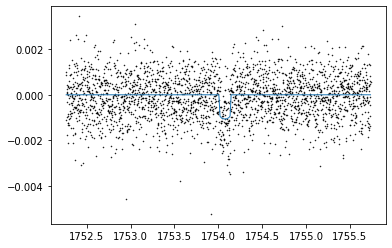

In [24]:
plt.plot(t, y, ".k", ms=1, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")

In [25]:
np.random.seed(42)
with model:
    trace = pm.sample(
        tune=3000,
        draws=3000,
        start=map_soln,
        chains=4,
        step=xo.get_dense_nuts_step(target_accept=0.9),
    )

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (4 chains in 1 job)
NUTS: [b, r, u, logP, t0, mean]
100%|██████████| 6000/6000 [00:31<00:00, 190.59it/s]


In [26]:
pm.summary(trace, varnames=["logP", "t0", "r", "b", "u", "mean"])

/usr/local/lib/python3.6/dist-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
logP__0,15.848074,0.098836,8.240797e-04,15.651632,16.039046,14369.905559,1.000088
t0__0,1754.077576,0.001684,1.704361e-05,1754.074442,1754.080889,11193.107314,0.999858
r__0,0.033155,0.001022,9.736848e-06,0.031218,0.035239,10946.969837,1.000331
b__0,0.824314,0.011467,1.128586e-04,0.802913,0.846945,10692.825333,0.999890
u__0,0.256605,0.210440,1.984529e-03,0.000037,0.673836,9344.115410,1.000215
u__1,0.030178,0.189905,1.862857e-03,-0.344887,0.430501,9890.974439,0.999948
mean,-0.000072,0.000009,6.498164e-08,-0.000089,-0.000055,14311.390593,0.999861


In [0]:
!pip install corner


INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock


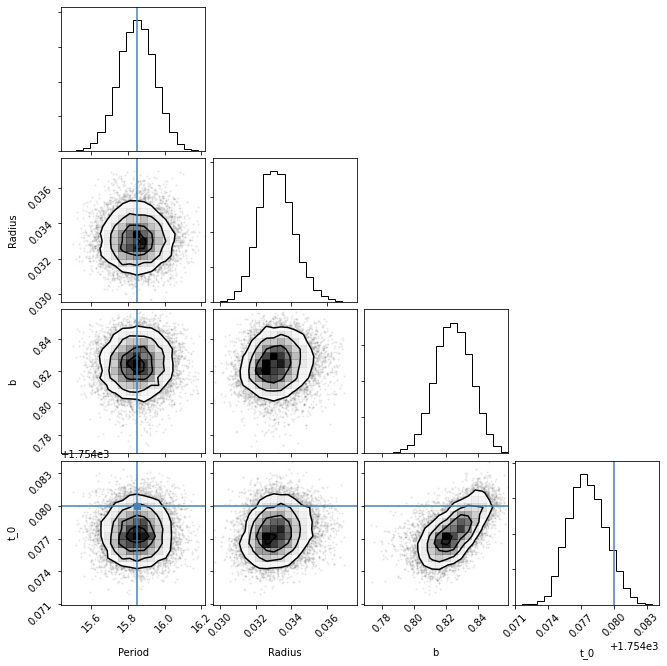

In [30]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["logP", "r", "b", "t0"])
truth = np.concatenate(xo.eval_in_model([logP, r, b, t0], model.test_point, model=model))
corner.corner(
    samples, truths=truth, labels=["Period", "Radius", "b", "t_0"]
);